In [1]:
!pip install sagemaker huggingface_hub --upgrade --q
!pip install python-dotenv --upgrade --q
!pip install diffusers --upgrade --q

In [76]:
import base64
import boto3
import json
import matplotlib.pyplot as plt
import os
import random
import sagemaker
import tarfile
import time
import torch

from diffusers import (
    StableCascadePriorPipeline,
    StableCascadeDecoderPipeline,
    StableCascadeUNet,
)
from distutils.dir_util import copy_tree
from dotenv import load_dotenv
from huggingface_hub import snapshot_download
from io import BytesIO
from pathlib import Path
from IPython.display import display
from PIL import Image
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader
from sagemaker.huggingface.model import HuggingFaceModel
from sagemaker.async_inference import AsyncInferenceConfig

load_dotenv()

sess = sagemaker.Session()
print(f"Sagemaker bucket: {sess.default_bucket()}")
print(f"Sagemaker session region: {sess.boto_region_name}")

Sagemaker bucket: sagemaker-us-east-1-329542461890
Sagemaker session region: us-east-1


In [26]:
HF_PRIOR_ID = "stabilityai/stable-cascade-prior"
HF_DECODER_ID = "stabilityai/stable-cascade"
CACHE_DIR = os.getenv("CACHE_DIR", "cache_dir")

prior_unet = StableCascadeUNet.from_pretrained(HF_PRIOR_ID, subfolder="prior_lite")
decoder_unet = StableCascadeUNet.from_pretrained(HF_DECODER_ID, subfolder="decoder_lite")

prior = StableCascadePriorPipeline.from_pretrained(
    HF_PRIOR_ID,
    variant="bf16",
    torch_dtype=torch.bfloat16,
    cache_dir=CACHE_DIR,
    prior=prior_unet,
)
decoder = StableCascadeDecoderPipeline.from_pretrained(
    HF_DECODER_ID,
    variant="bf16",
    torch_dtype=torch.bfloat16,
    cache_dir=CACHE_DIR,
    decoder=decoder_unet,
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [77]:
model_path = "model/"
prior_path = "model/prior/"
decoder_path = "model/decoder/"
code_path = "code/"
cache_dir = "cache_dir/"

if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(code_path):
    os.mkdir(code_path)
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)
if not os.path.exists(prior_path):
    os.mkdir(prior_path)
if not os.path.exists(decoder_path):
    os.mkdir(decoder_path)

prior.save_pretrained(save_directory=prior_path)
decoder.save_pretrained(save_directory=decoder_path)

In [78]:
%%writefile code/requirements.txt
--find-links https://download.pytorch.org/whl/torch_stable.html
accelerate>=0.25.0
torch==2.1.2+cu118
torchvision==0.16.2+cu118
transformers>=4.30.0
numpy>=1.23.5
kornia>=0.7.0
insightface>=0.7.3
opencv-python>=4.8.1.78
tqdm>=4.66.1
matplotlib>=3.7.4
webdataset>=0.2.79
wandb>=0.16.2
munch>=4.0.0
onnxruntime>=1.16.3
einops>=0.7.0
onnx2torch>=1.5.13
warmup-scheduler @ git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
torchtools @ git+https://github.com/pabloppp/pytorch-tools
diffusers

Overwriting code/requirements.txt


In [108]:
%%writefile code/inference.py
import base64
import json
import os
import torch

from diffusers import StableCascadePriorPipeline, StableCascadeDecoderPipeline
from io import BytesIO


def model_fn(model_dir):
    """
    Load the model for inference
    """
    print("Entering model_fn...")
    print(f"Model Directory is {model_dir}")

    prior = StableCascadePriorPipeline.from_pretrained(f"{model_dir}/prior", local_files_only=True)
    decoder = StableCascadeDecoderPipeline.from_pretrained(
        f"{model_dir}/decoder", local_files_only=True
    )

    model_dict = {"prior": prior, "decoder": decoder}
    print(f"model dictionary: {model_dict}")
    return model_dict


def predict_fn(input_data, model_dict):
    """
    Apply model to the incoming request
    """
    print("Entering predict_fn...")
    prior = model_dict["prior"]
    decoder = model_dict["decoder"]

    print(f"Processing input_data {input_data}")
    prompt = input_data["prompt"]
    negative_prompt = input_data["negative_prompt"]
    print(f"Prompt = {prompt}")
    print(f"Negative Prompt = {negative_prompt}")

    prior.enable_model_cpu_offload()
    prior_output = prior(
        prompt=prompt,
        height=1024,
        width=1024,
        negative_prompt=negative_prompt,
        guidance_scale=4.0,
        num_images_per_prompt=1,
        num_inference_steps=20,
    )

    decoder.enable_model_cpu_offload()
    decoder_output = decoder(
        image_embeddings=prior_output.image_embeddings,
        prompt=prompt,
        negative_prompt=negative_prompt,
        guidance_scale=0.0,
        output_type="pil",
        num_inference_steps=10,
    ).images[0]

    encoded_images = []
    buffered = BytesIO()
    decoder_output.save(buffered, format="JPEG")
    encoded_images.append(base64.b64encode(buffered.getvalue()).decode())
    # decoded_images = []
    # decoded_images.extend(decoder_output)

    # for image in decoded_images:
    #     buffered = BytesIO()
    #     image.save(buffered, format="JPEG")
    #     encoded_images.append(base64.b64encode(buffered.getvalue()).decode())
    print("Finished encodeing returned images.")
    return {"generated_images": encoded_images}

Overwriting code/inference.py


In [92]:
# UNCOMMENT if planning to test local inference
# Perform local inference in notebook to validate model loading and inference call

# prior = StableCascadePriorPipeline.from_pretrained(prior_path, local_files_only=True)
# decoder = StableCascadeDecoderPipeline.from_pretrained(decoder_path, local_files_only=True)
# prompt = "an image of a shiba inu, donning a spacesuit and helmet"
# negative_prompt = ""

# prior.enable_model_cpu_offload()
# prior_output = prior(
#     prompt=prompt,
#     height=1024,
#     width=1024,
#     negative_prompt=negative_prompt,
#     guidance_scale=4.0,
#     num_images_per_prompt=1,
#     num_inference_steps=20
# )

# decoder.enable_model_cpu_offload()
# decoder_output = decoder(
#     image_embeddings=prior_output.image_embeddings,
#     prompt=prompt,
#     negative_prompt=negative_prompt,
#     guidance_scale=0.0,
#     output_type="pil",
#     num_inference_steps=10
# ).images[0]
# decoder_output.save("cascade.png")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [109]:
# assemble model package
model_tar = Path(f"model-{random.getrandbits(16)}")
model_tar.mkdir(exist_ok=True)

copy_tree(prior_path, str(model_tar.joinpath("prior")))
copy_tree(decoder_path, str(model_tar.joinpath("decoder")))
copy_tree(code_path, str(model_tar.joinpath("code")))

['model-48646/code/requirements.txt',
 'model-48646/code/inference.py',
 'model-48646/code/.ipynb_checkpoints/inference-checkpoint.py']

In [ ]:
# helper to create the model.tar.gz
def compress(tar_dir=None, output_file="model.tar.gz"):
    parent_dir = os.getcwd()
    os.chdir(tar_dir)
    with tarfile.open(os.path.join(parent_dir, output_file), "w:gz") as tar:
        for item in os.listdir("."):
            print(item)
            tar.add(item, arcname=item)
    os.chdir(parent_dir)


compress(str(model_tar))

prior
decoder


In [ ]:
# upload model.tar.gz to s3
s3_model_uri = S3Uploader.upload(
    local_path="model.tar.gz",
    desired_s3_uri=f"s3://{sess.default_bucket()}/stable-cascade",
)
print(f"model uploaded to: {s3_model_uri}")

In [ ]:
%cd

In [ ]:
# helper decoder
def decode_base64_image(image_string):
    base64_image = base64.b64decode(image_string)
    buffer = BytesIO(base64_image)
    return Image.open(buffer)


# display PIL images as grid
def display_images(images=None, columns=3, width=100, height=100):
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.axis("off")
        plt.imshow(image)

In [118]:
# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
    model_data=s3_model_uri,
    role=get_execution_role(sess),
    transformers_version="4.17",  # transformers version used
    pytorch_version="1.10",  # pytorch version used
    py_version="py38",  # python version used
)

async_config = AsyncInferenceConfig(
    output_path=f"s3://{sess.default_bucket()}/stable-cascade/inference/output",
    max_concurrent_invocations_per_instance=10,
    notification_config={
        "SuccessTopic": "arn:aws:sns:us-east-1:329542461890:stability-cascade-success-topic",
        "ErrorTopic": "arn:aws:sns:us-east-1:329542461890:stability-cascade-error-topic",
    },
)

# deploy the endpoint endpoint
predictor = huggingface_model.deploy(
    # initial_instance_count=4,
    # instance_type="ml.g4dn.xlarge",
    # initial_instance_count=2,
    initial_instance_count=1,
    instance_type="ml.g5.48xlarge",
    # instance_type="ml.p3.8xlarge",
    # volume_size=512
    # async_inference_config=async_config
)

---------------!

inference response: {'ResponseMetadata': {'RequestId': '225664de-9103-4278-ac19-c8e804dca410', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '225664de-9103-4278-ac19-c8e804dca410', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Sat, 13 Apr 2024 01:33:18 GMT', 'content-type': 'application/json', 'content-length': '100493', 'connection': 'keep-alive'}, 'RetryAttempts': 0}, 'ContentType': 'application/json', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7f09f2d66530>}
total inference time = 15.722858428955078


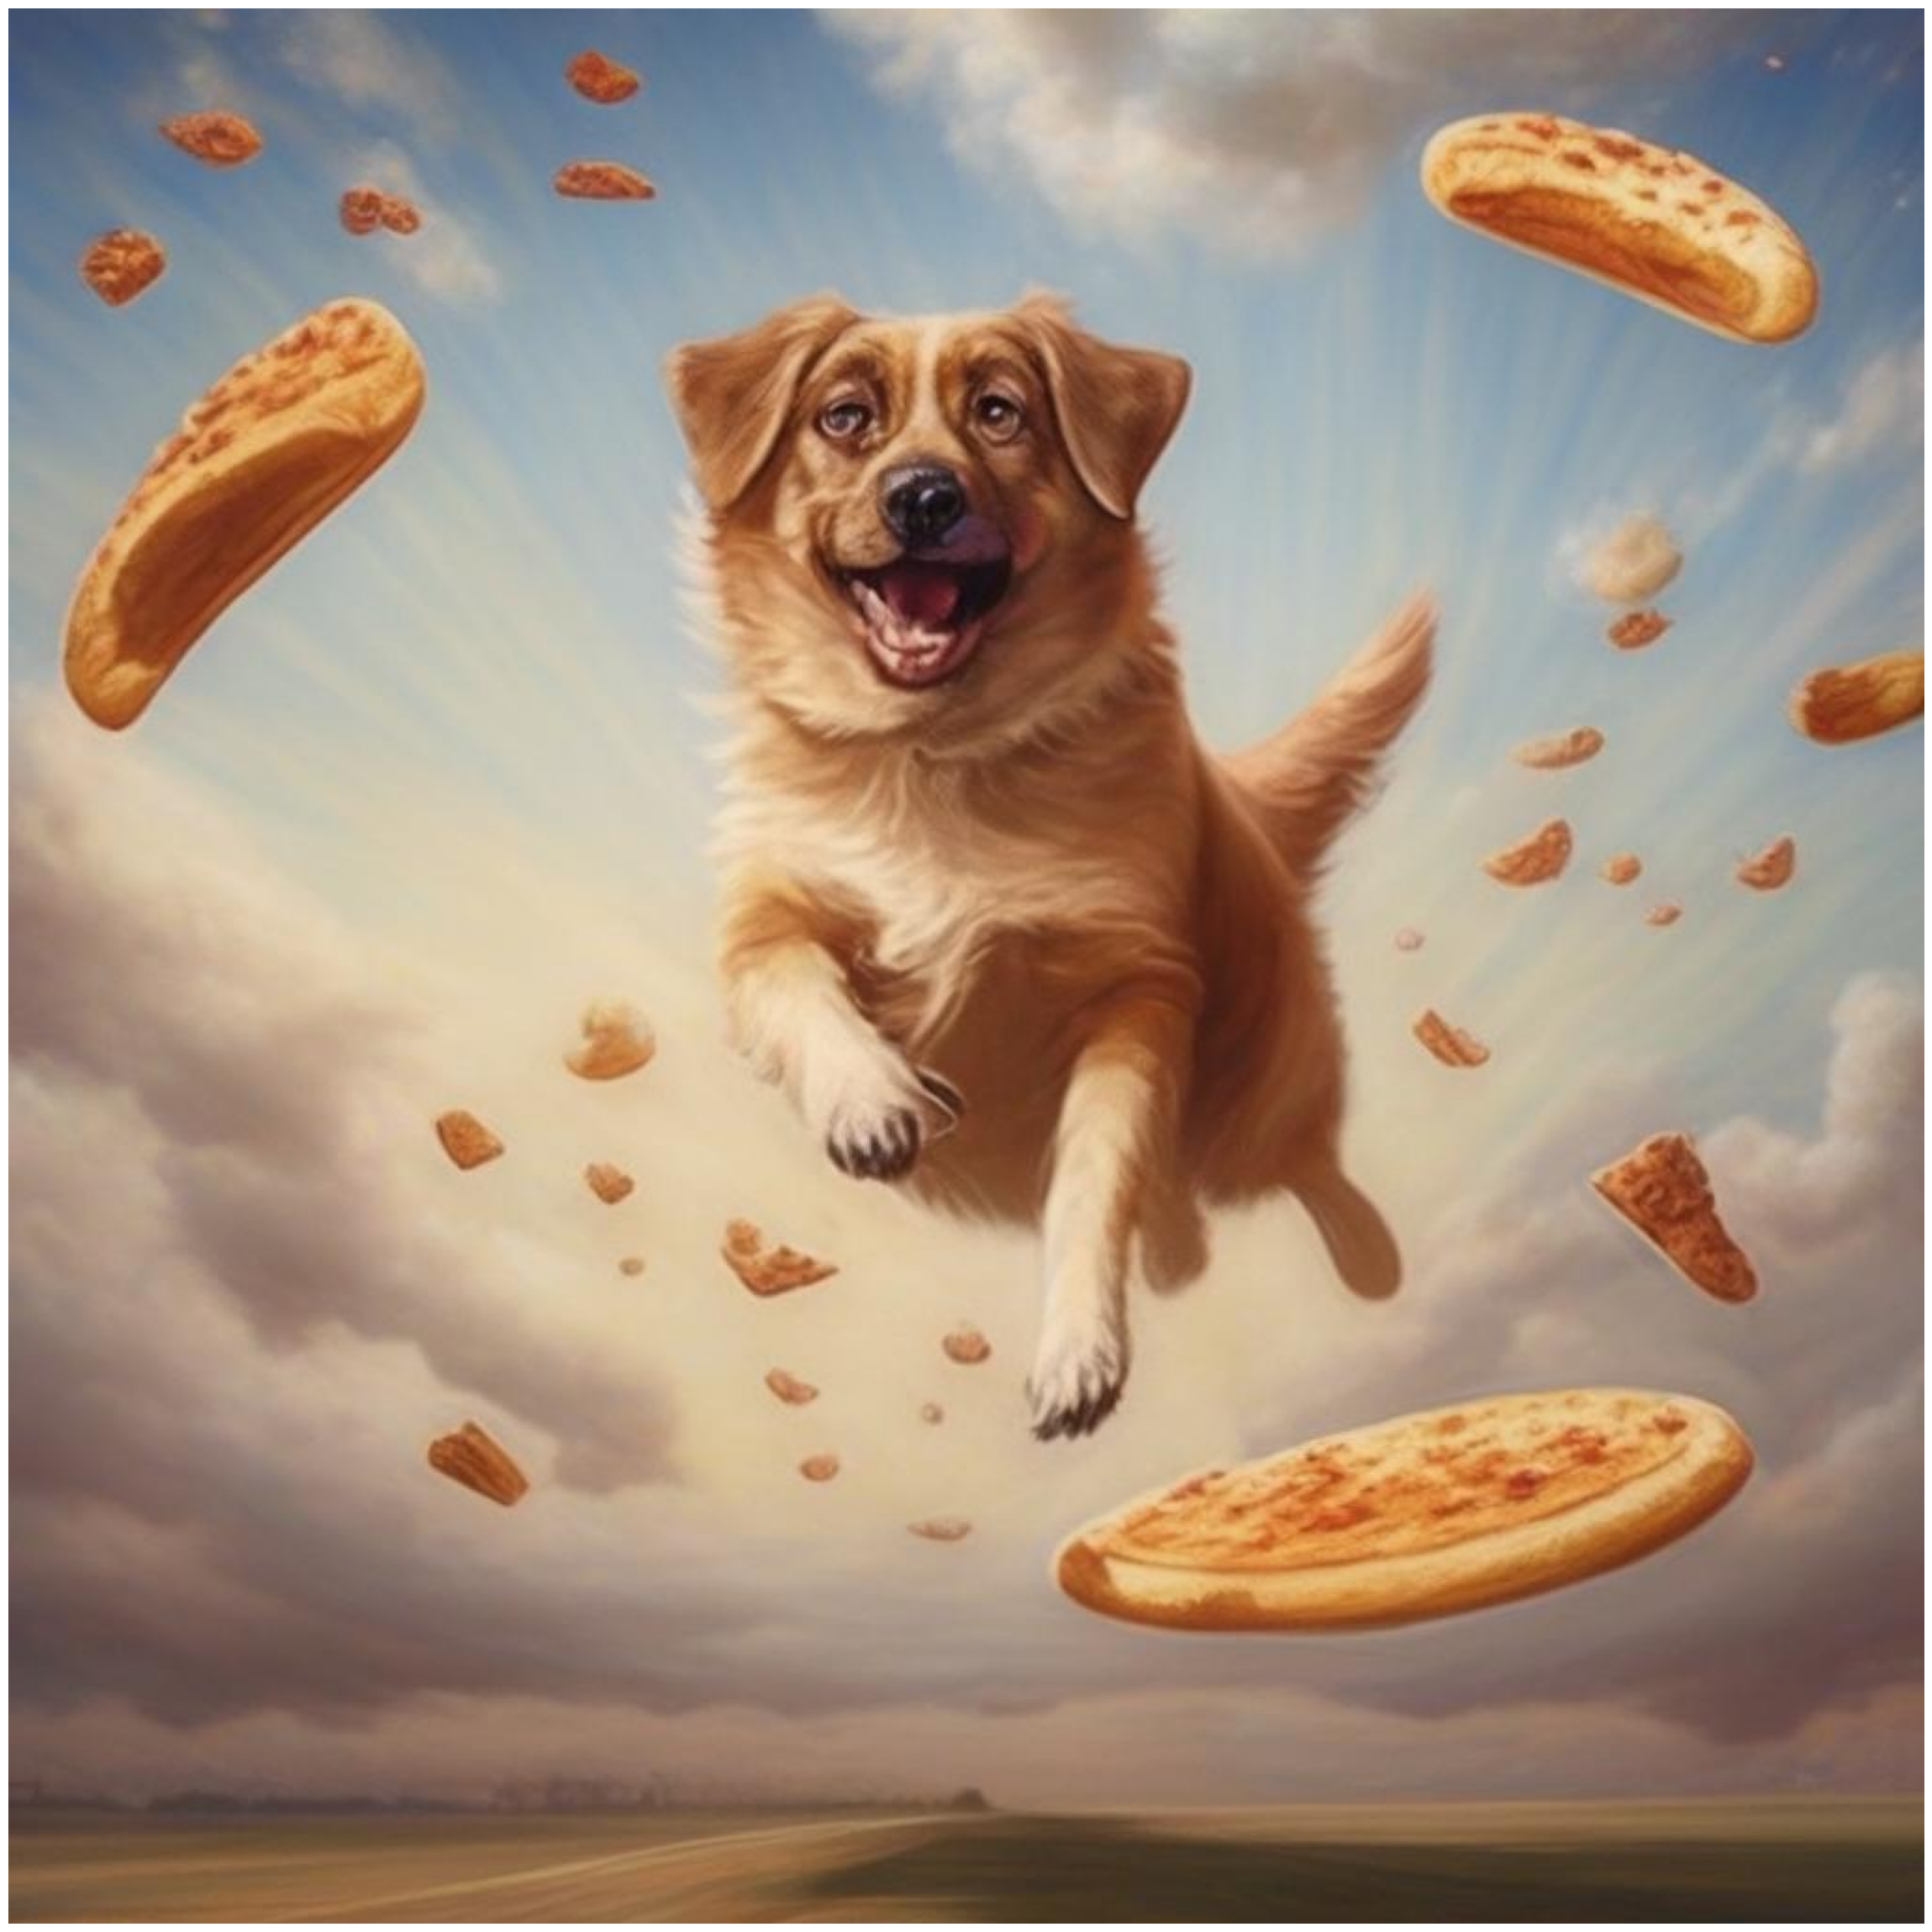

In [119]:
start_time = time.time()

# invoke_endpoint_async API call
client = boto3.client("sagemaker-runtime")
prompt = "A dog trying to catch a flying pizza art"
num_images_per_prompt = 1
payload = {"prompt": prompt, "negative_prompt": ""}

serialized_payload = json.dumps(payload, indent=4)
with open("payload.json", "w") as outfile:
    outfile.write(serialized_payload)

# s3_payload_uri=S3Uploader.upload(local_path="payload.json", desired_s3_uri=f"s3://{sess.default_bucket()}/stable-cascade/inference/input")
# print(f"async inference payload: {serialized_payload}")
# print(f"model uploaded to: {s3_payload_uri}")

# response = client.invoke_endpoint_async(
#     EndpointName=predictor.endpoint_name,
#     ContentType='application/json',  # Specify the format of the payload
#     Accept='application/json',
#     InputLocation=s3_payload_uri,
#     RequestTTLSeconds=3600,
#     InvocationTimeoutSeconds=3600
# )
# print(f"async inference response: {response}")

response = client.invoke_endpoint(
    EndpointName=predictor.endpoint_name,
    ContentType="application/json",  # Specify the format of the payload
    Accept="application/json",
    Body=serialized_payload,
)
print(f"inference response: {response}")

response_payload = json.loads(response["Body"].read().decode("utf-8"))

# decode images
decoded_images = [decode_base64_image(image) for image in response_payload["generated_images"]]

# visualize generation
display_images(decoded_images)

end_time = time.time()
inference_time = end_time - start_time
print(f"total inference time = {inference_time}")